### SimData  : Proportions of each clone

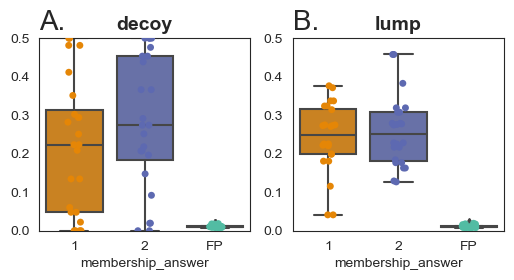

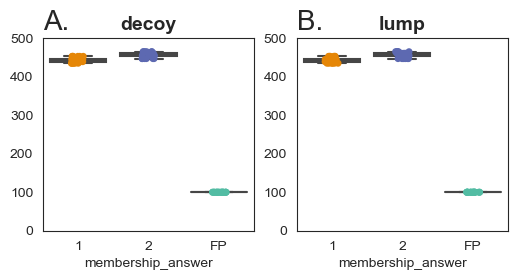

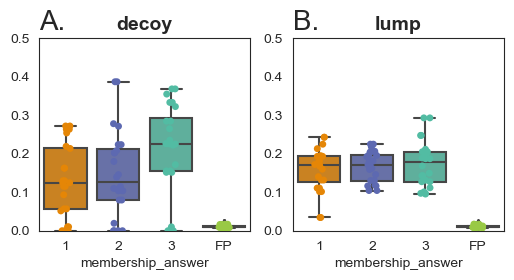

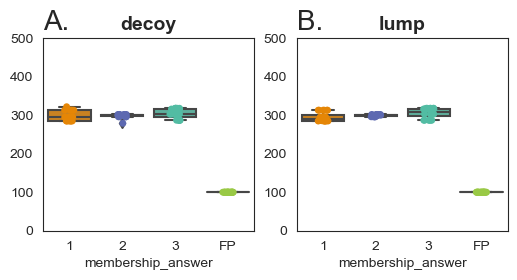

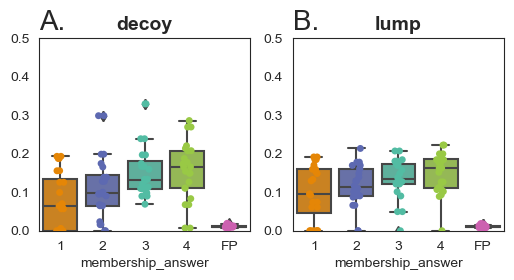

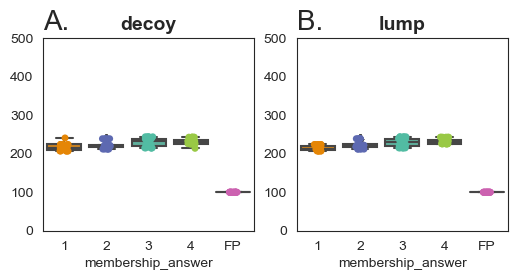

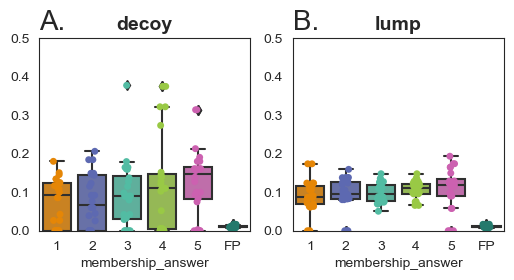

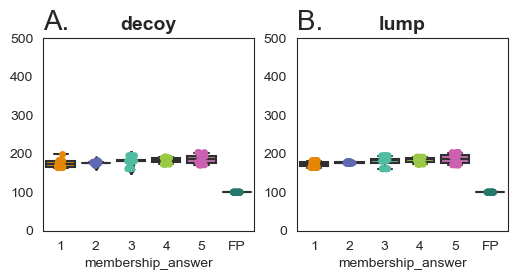

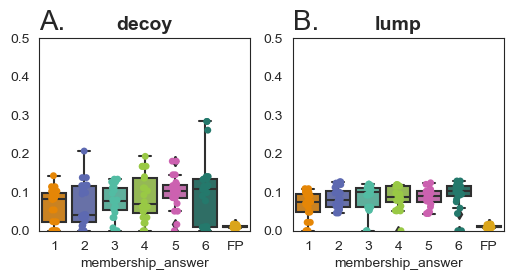

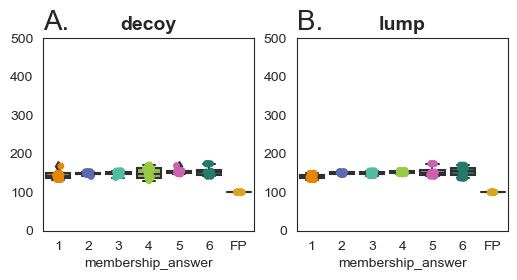

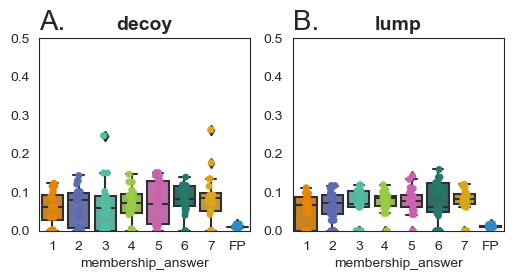

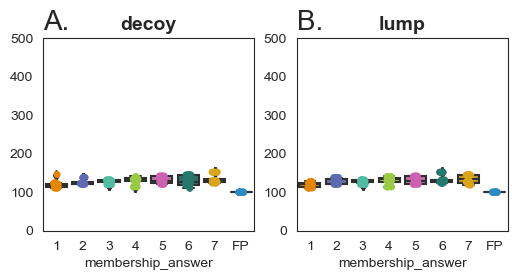

In [25]:
def drawfigure (long_df, ax, ax_no, title, x_order, y):
    import matplotlib 
    matplotlib.rcParams["font.family"] = 'arial'
    import palettable
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ttest_ind

    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors

    colorlist = [i for i in safe7]
    sns.set_style("white")
    #sns.set_palette("tab10")
    sns.set_palette(sns.color_palette(colorlist))


    # Create a grouped bar graph    
    sns.stripplot(data = long_df, x = 'membership_answer', y = y, alpha = 1.0, order = x_order, ax = ax[ax_no])
    sns.boxplot(data = long_df, x = 'membership_answer', y = y, order = x_order, ax = ax[ax_no]  )

    ax[ax_no].set_title (title, fontsize = 14, fontweight = "semibold")


def long_df_modify (long_df, col):
    import numpy as np

    # 제일 큰 건 FP_index
    FP_index = len ( np.array ( long_df.groupby("membership_answer")[ col ].mean() ) )  - 1

    # argsort를 이용해서 변환표 작성
    clone_dict = {}
    new_index = 0
    for prev_index  in np.argsort ( np.array ( long_df.groupby("membership_answer")[ col ].mean() )  )  :
        if prev_index == FP_index:  # FP
            clone_dict [FP_index] = "FP"
        else:
            clone_dict [prev_index] = new_index + 1
            new_index +=1

    # 새로운 membership_answer_new를 만들어줌
    new_col = []
    for k in range (long_df.shape[0]):
        if long_df.loc[k]["membership_answer"] != "FP":
            new_col.append ( str ( clone_dict [ int ( long_df.loc[k]["membership_answer"] ) ] ) )
        else:
            new_col.append ( "FP" )
        
    long_df ["membership_answer_new"] = new_col
    long_df ["membership_answer"] = new_col

    return long_df

########################################### MAIN  ##########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, glob

kwargs = {}

NUM_BLOCK_LIST = [ 1, 2, 3 ]             # 1, 2, 3
NUM_MUTATION_LIST = [ 1000 ]    # 100, 500, 1000
DEPTH_MEAN_LIST = [ 250 ]       # 250, 125, 30
FP_RATIO_LIST = [ 0.1  ]        # 0.0, 0.1
SIMDATA_LIST = [ "decoy", "lump" ] # "decoy", "lump"
NUM_CLONE_LIST = [2, 3, 4, 5, 6, 7]      # 2, 3, 4, 5, 6, 7


for NUM_CLONE in NUM_CLONE_LIST:
    for FP_RATIO in FP_RATIO_LIST:
        fig1, ax1 = plt.subplots( nrows = 1, ncols = 2, figsize = (6, 2.5))
        fig2, ax2 = plt.subplots( nrows = 1, ncols = 2, figsize = (6, 2.5))

        for ax_no, SIMDATA in enumerate(SIMDATA_LIST):        
            long_df = pd.DataFrame ( columns = ["membership_answer", "clone", "meanVAF"] )
            long_df_count = pd.DataFrame ( columns = ["membership_answer", "clone", "count"] )
        
            for NUM_MUTATION in NUM_MUTATION_LIST:
                for NUM_BLOCK in NUM_BLOCK_LIST:
                    for DEPTH_MEAN in DEPTH_MEAN_LIST:
                        INPUT_TSV_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/02.npvaf/1.SimData/SimData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/" + str (SIMDATA) + "/" + str(FP_RATIO) + "/clone_" + str(NUM_CLONE) +  "/*/npvaf.txt" ) )

                        for INPUT_TSV in INPUT_TSV_LIST:
                            if not os.path.exists ( INPUT_TSV ):
                                print (INPUT_TSV + "없음")
                                continue
                            df = pd.read_csv (INPUT_TSV, sep = "\t", index_col = 0)
                            tt = pd.melt ( df.groupby( 'membership_answer' ).mean().reset_index(), id_vars=['membership_answer'], var_name='clone', value_name='meanVAF')
                            uu = pd.melt ( df.groupby( 'membership_answer' ).count().reset_index(), id_vars=['membership_answer'], var_name='clone', value_name='count')

                            long_df = long_df.append( tt , ignore_index = True) 
                            long_df_count = long_df_count.append( uu, ignore_index = True) 

            long_df = long_df_modify (long_df, "meanVAF")
            long_df_count = long_df_modify (long_df_count, "count")
            
            drawfigure (long_df, ax1, ax_no, SIMDATA, x_order =  [str(i) for i in np.arange (1, NUM_CLONE + 1)] + ["FP"] , y = "meanVAF")
            drawfigure (long_df_count, ax2, ax_no, SIMDATA,  x_order = [str(i) for i in np.arange (1, NUM_CLONE + 1)] + ["FP"] , y = "count")
    
        for k, ax1_individual in enumerate(ax1):
            ax1_individual.set_title (chr (k+65) + "." , fontsize = 20, loc = "left")    # A. B. C.
            ax1_individual.set_ylim (0, 0.5)
            ax1_individual.set_ylabel (None)
        fig1.savefig ( "/data/project/Alzheimer/YSscript/cle/Revision/Simdata_proportions/meanVAF_clone" + str(NUM_CLONE) + ".jpg" , dpi = 300 )
        fig1.show()
        
        for k, ax2_individual in enumerate(ax2):
            ax2_individual.set_title (chr (k+65) + "." , fontsize = 20, loc = "left")    # A. B. C.
            ax2_individual.set_ylim (0,500)
            ax2_individual.set_ylabel (None)
        fig2.savefig ( "/data/project/Alzheimer/YSscript/cle/Revision/Simdata_proportions/count_clone" + str(NUM_CLONE) + ".jpg" , dpi = 300 )
        fig2.show()

    


### CellData : FP densitogram

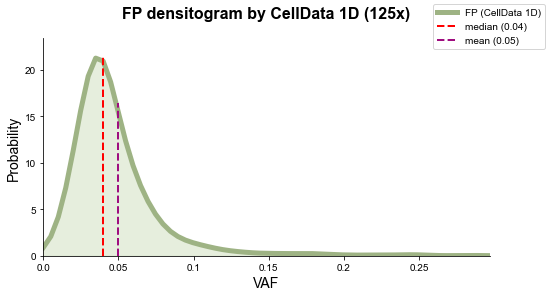

In [6]:
def visualization (vaf_list, **kwargs):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as kde

    matplotlib.rcParams["font.family"] ="arial"
    fig, ax = plt.subplots (figsize = (8, 4))
    #ax.set_yticks ( np.arange (0, np.max(y), 0.1))

    ax.set_title ( "FP densitogram by CellData 1D ({}x)".format(kwargs["DEPTH_MEAN"]), fontsize = 16, fontweight='bold', color='black', pad=20)

    x = np.linspace(0, 1, 200)
    kde_function = kde.gaussian_kde( vaf_list )
    y = kde_function(x) 

    ax.plot (x, y, label = "FP (CellData 1D)", linewidth = 5, color = '#9EB384')
    ax.fill_between(x, y, color='#CEDEBD', alpha=0.5)

    # median & mean
    ax.axvline(x = np.median (vaf_list),  ymin = 0, ymax = kde_function ( np.median(vaf_list) ) [0] / plt.ylim()[1]  * 0.97 , label = "median ({})".format ( round ( np.median(vaf_list), 2) ), linestyle='--', linewidth=2, color = 'red' )       
    ax.axvline(x = np.mean (vaf_list),  ymin = 0, ymax = kde_function ( np.mean(vaf_list) ) [0] / plt.ylim()[1]  , label = "mean ({})".format (round (np.mean (vaf_list), 2) ), linestyle='--', linewidth=2, color = '#9F0D7F' )       

    # 축 설정
    ax.set_xticks (  np.linspace (0, 1.01, 21) )
    ax.set_xticklabels (  np.round ( np.linspace (0, 1.01, 21), 2 ) )
    ax.set_xlabel("VAF", fontdict = {"fontsize" : 14})
    ax.set_ylabel("Probability", fontdict = {"fontsize" : 14})
    ax.axis ( [0, 0.3, 0, np.max (y) * 1.1] )

    # Spine 설정
    fig.gca().spines['top'].set_visible(False)
    fig.gca().spines['right'].set_visible(False)
    fig.legend()


if __name__ == "__main__":
    import numpy as np
    import os,re
    import pandas as pd

    kwargs = {"DEPTH_MEAN" : 125}
    DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/2.CellData/CellData_1D/" + str(kwargs["DEPTH_MEAN"]) + "x"

    vaf_list =  []


    for filename in sorted(os.listdir (DIR)):
        kwargs["SAMPLENAME"] = re.split(r'[_ .]', filename)[0]
        if os.path.isdir( DIR + "/" + filename ) == True:
            continue

        inputdf = pd.read_csv ( DIR + "/" + filename, sep = "\t", header = None)

        if inputdf.shape[1] == 3: #  If 4th column (BQ) is absent
            inputdf.columns = ["pos", "sample", "info"]
            inputdf.astype ({"pos":"str", "sample":"str", "info":"str"})
        elif inputdf.shape[1] == 4: #  If 4th column (BQ) is present
            inputdf.columns = ["pos", "sample", "info", "BQ"]
            inputdf.astype ({"pos":"str", "sample":"str", "info":"str", "BQ":"str"})

        for k in range (inputdf.shape[0]):
            depth = int ( inputdf.iloc[k]["info"].split(",")[0] ) 
            alt = int ( inputdf.iloc[k]["info"].split(",")[1] ) 
            vaf = round (alt / depth, 3) 

            if inputdf.iloc[k]["sample"] == "FP":
                vaf_list.append ( vaf )
            
        #print ( "{} : vaf_list = {}".format (kwargs ["SAMPLENAME"], len(vaf_list) ) )

    visualization ( np.array (vaf_list) , ** kwargs)

### CellData : VAF - FP probability (2023.08.04)

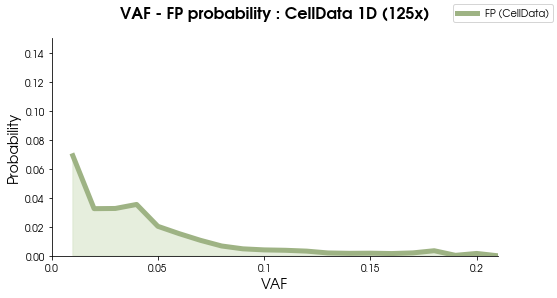

In [5]:
def visualization (vaf_fP_ratio, **kwargs):
    import matplotlib.pyplot as plt

    x = np.arange (0, 101, 1)
    y = np.array ( [ vaf_fp_ratio[i] for i in x] )

    fig, ax = plt.subplots (figsize = (8, 4))
    #ax.set_yticks ( np.arange (0, np.max(y), 0.1))

    ax.set_title ( "VAF - FP probability : CellData 1D ({}x)".format(kwargs["DEPTH_MEAN"]), fontsize = 16, fontweight='bold', color='black', pad=20)

    ax.plot (x, y, label = "FP (CellData)", linewidth = 5, color = '#9EB384')
    ax.fill_between(x, y, color='#CEDEBD', alpha=0.5)
    #ax.axvline(x = 0.02,  ymin = 0, ymax = TN_prior_cal (0.02)/plt.ylim()[1] * 1.03, label = "median", linestyle='--', linewidth=2, color = 'red' )

    # 축 설정
    ax.set_xticks (  np.arange (0, 101, 5) )
    ax.set_xticklabels (  np.round ( np.arange (0, 1.01, 0.05), 2 ) )
    ax.set_xlabel("VAF", fontdict = {"fontsize" : 14})
    ax.set_ylabel("Probability", fontdict = {"fontsize" : 14})
    ax.axis ( [0, 21, 0, 0.15] )

    # Spine 설정
    fig.gca().spines['top'].set_visible(False)
    fig.gca().spines['right'].set_visible(False)
    fig.legend()



if __name__ == "__main__":
    import numpy as np
    import os,re
    import pandas as pd

    kwargs = {"DEPTH_MEAN" : 125}
    DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/2.CellData/CellData_1D/" + str(kwargs["DEPTH_MEAN"]) + "x"

    vaf_cnt =  np.array([ [0, 0] ] * 101 )
    vaf_fp_ratio = [ [] ] * 101


    for filename in sorted(os.listdir (DIR)):
        kwargs["SAMPLENAME"] = re.split(r'[_ .]', filename)[0]
        #print ( kwargs ["SAMPLENAME"])
        if os.path.isdir( DIR + "/" + filename ) == True:
            continue

        inputdf = pd.read_csv ( DIR + "/" + filename, sep = "\t", header = None)

        if inputdf.shape[1] == 3: #  If 4th column (BQ) is absent
            inputdf.columns = ["pos", "sample", "info"]
            inputdf.astype ({"pos":"str", "sample":"str", "info":"str"})
        elif inputdf.shape[1] == 4: #  If 4th column (BQ) is present
            inputdf.columns = ["pos", "sample", "info", "BQ"]
            inputdf.astype ({"pos":"str", "sample":"str", "info":"str", "BQ":"str"})

        for k in range (inputdf.shape[0]):
            depth = int ( inputdf.iloc[k]["info"].split(",")[0] ) 
            alt = int ( inputdf.iloc[k]["info"].split(",")[1] ) 
            vaf = int ( np.round (alt / depth, 2) * 100 )

            if inputdf.iloc[k]["sample"] == "FP":
                vaf_cnt [vaf][0] = vaf_cnt [vaf][0] + 1
            else:
                vaf_cnt [vaf][1] = vaf_cnt [vaf][1] +  1

    for k in range (len (vaf_cnt)):
        if (vaf_cnt[k][0]  + vaf_cnt[k][1] ) == 0:
            vaf_fp_ratio[k] = np.nan
        else:
            if (vaf_cnt[k][0]  + vaf_cnt[k][1] ) < 200:
                vaf_fp_ratio[k] = np.nan
            else:
                vaf_fp_ratio[k] = vaf_cnt[k][0] / (vaf_cnt[k][0]  + vaf_cnt[k][1] )

    visualization (vaf_fp_ratio, **kwargs)

---

### SimData : VAF - FP probability (2023.08.03)

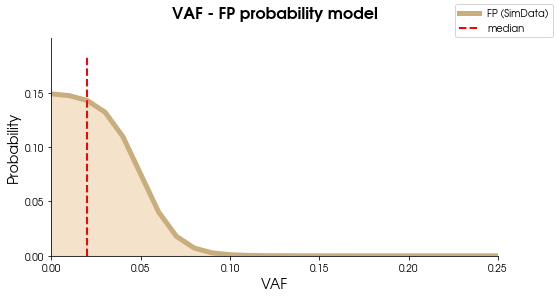

In [3]:
def TN_prior_cal(x):
    from scipy.special import expit
    return (1 - expit( 100*x - 5)) * 0.15

if __name__ == "__main__":
    import numpy as np
    import matplotlib
    matplotlib.rcParams["font.family"] = "URW Gothic"
    import matplotlib.pyplot as plt
    
    x = np.linspace(0, 1, 101)
    y = np.array ( [TN_prior_cal(i) for i in x] )

    fig, ax = plt.subplots (figsize = (8, 4))
    ax.set_yticks ( np.arange (0, np.max(y) * 1.1, 0.05))

    ax.set_title ( "VAF - FP probability model", fontsize = 16, fontweight='bold', color='black', pad=20)

    ax.plot (x, y, label = "FP (SimData)", linewidth = 5, color = '#C8AE7D')
    ax.fill_between(x, y, color='#EAC696', alpha=0.5)
    ax.axvline(x = 0.02,  ymin = 0, ymax = TN_prior_cal (0.02)/plt.ylim()[1] , label = "median", linestyle='--', linewidth=2, color = 'red' )

    # 축 설정
    ax.set_xlabel("VAF", fontdict = {"fontsize" : 14})
    ax.set_ylabel("Probability", fontdict = {"fontsize" : 14})
    ax.axis ( [0, 0.25, 0, 0.2] )

    # Spine 설정
    fig.gca().spines['top'].set_visible(False)
    fig.gca().spines['right'].set_visible(False)
    fig.legend()

### SimData : FP densitogram (2023.08.03)


======================	1.SimData_2D/n500_100x/decoy/0.0	===============================

======================	1.SimData_2D/n500_100x/decoy/0.1	===============================

======================	1.SimData_2D/n500_100x/lump/0.0	===============================

======================	1.SimData_2D/n500_100x/lump/0.1	===============================


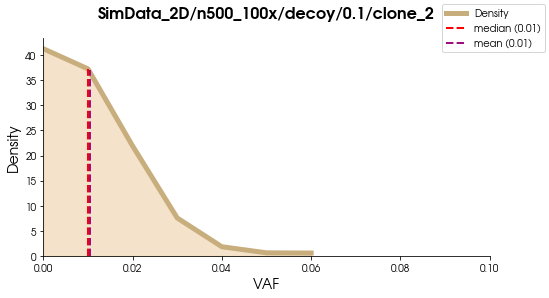

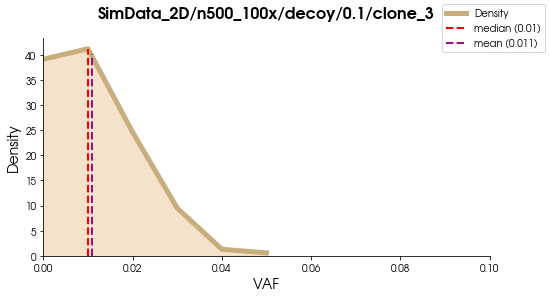

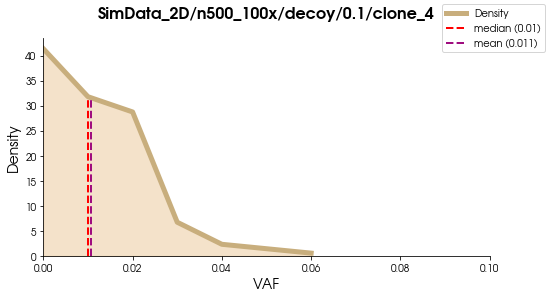

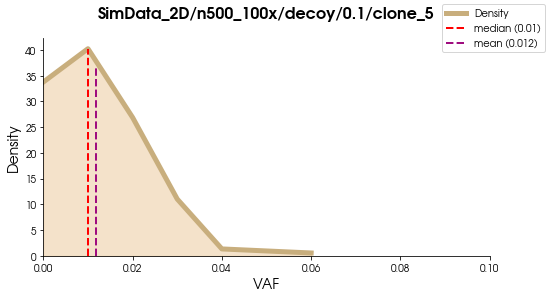

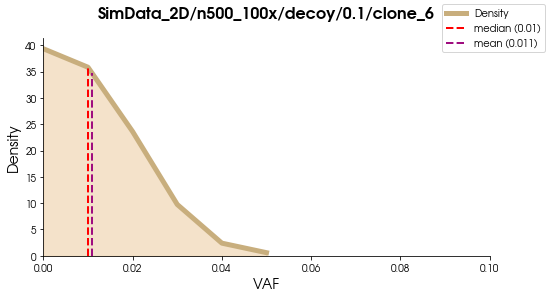

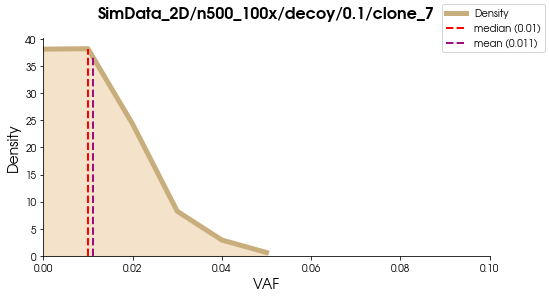

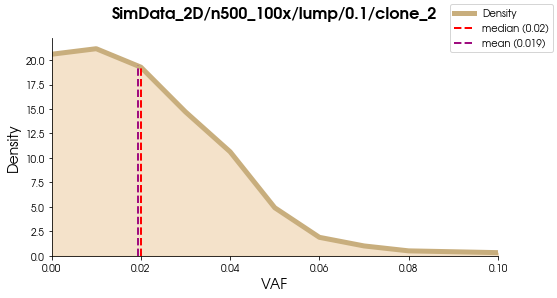

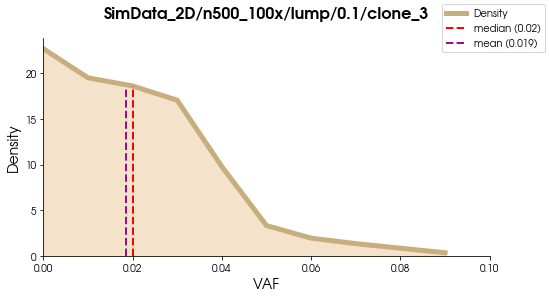

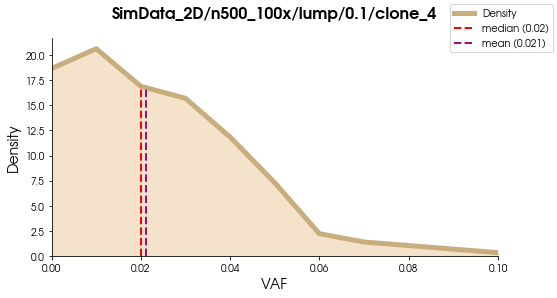

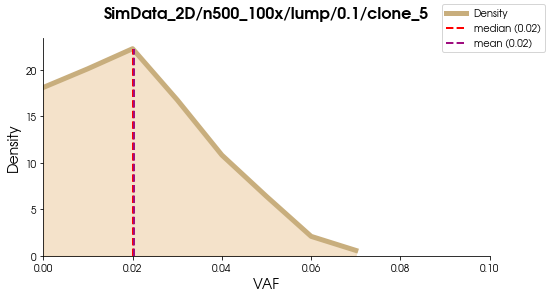

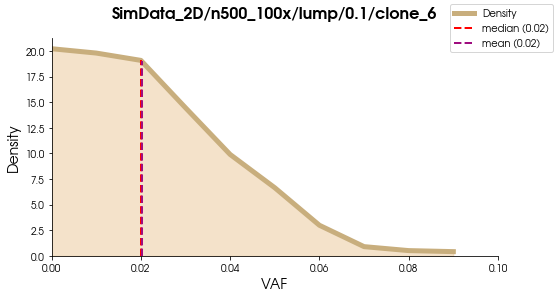

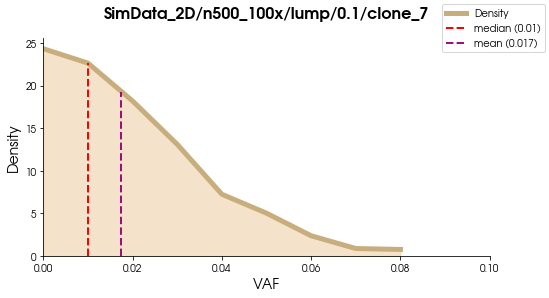

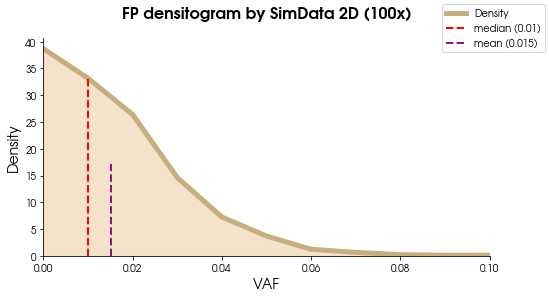

In [12]:
def draw_fp_densitogram (x, TITLE):
    import numpy as np
    from scipy.stats import gaussian_kde
    import matplotlib
    matplotlib.rcParams["font.family"] = "URW Gothic"
    import matplotlib.pyplot as plt

    if len (x) != 0:           # FP = 0 이고 비어있으면 아예 densitogram 안됨
        x = sorted ( np.array (x) )
        kde_function = gaussian_kde( x )
        y = kde_function (x)


        fig, ax = plt.subplots (figsize = (8, 4))
        #ax.set_yticks ( np.arange (0, np.max(y), 0.1))

        ax.set_title ( TITLE, fontsize = 16, fontweight='bold', color='black', pad=20)

        ax.plot (x, y, label = "Density", linewidth = 5, color = '#C8AE7D')
        ax.fill_between(x, y, color = '#EAC696', alpha=0.5)
        ax.axvline(x = np.median (x),  ymin = 0, ymax = kde_function ( np.median(x) ) [0] / plt.ylim()[1] , label = "median ({})".format ( round ( np.median(x), 3) ), linestyle='--', linewidth=2, color = 'red' )       
        ax.axvline(x = np.mean (x),  ymin = 0, ymax = kde_function ( np.mean(x) ) [0] / plt.ylim()[1]  , label = "mean ({})".format (round (np.mean (x), 3) ), linestyle='--', linewidth=2, color = '#9F0D7F' )       

        # 축 설정
        ax.set_xlabel("VAF", fontdict = {"fontsize" : 14})
        ax.set_ylabel("Density", fontdict = {"fontsize" : 14})
        ax.axis ( [0, 0.1, 0, np.max (y) * 1.05] )

        # Spine 설정
        fig.gca().spines['top'].set_visible(False)
        fig.gca().spines['right'].set_visible(False)
        fig.legend()




if __name__ == "__main__":    
    import os
    import pandas as pd

    kwargs = {}

    NUM_BLOCK_LIST = [2]             # 1, 2, 3
    NUM_MUTATION_LIST = [500]    # 500, 100
    DEPTH_MEAN_LIST = [100]       # 100, 30
    FP_RATIO_LIST = [0.0, 0.1 ]        # 0.0, 0.1
    SIMDATA_LIST = [ "decoy", "lump"] # "decoy", "lump"
    NUM_CLONE_LIST = [ 2, 3, 4, 5, 6, 7 ]      # 2, 3, 4, 5, 6, 7
    BENCHMARK_LIST = [0, 1, 2]; kwargs["BENCHMARK_START"] = BENCHMARK_LIST[0];  kwargs["BENCHMARK_END"] = BENCHMARK_LIST[1]

    x_total = []
    for NUM_BLOCK in NUM_BLOCK_LIST:
        for NUM_MUTATION in NUM_MUTATION_LIST:
            for DEPTH_MEAN in DEPTH_MEAN_LIST:        
                for SIMDATA in SIMDATA_LIST:
                    for FP_RATIO in FP_RATIO_LIST:
                        print("\n======================\t1.SimData_{}D/n{}_{}x/{}/{}\t===============================".format( NUM_BLOCK ,NUM_MUTATION, DEPTH_MEAN, SIMDATA, FP_RATIO ))            
                        for NUM_CLONE in NUM_CLONE_LIST:
                            x_regional = []
                            for ii in range(kwargs["BENCHMARK_START"],  kwargs["BENCHMARK_END"] + 1):
                                kwargs["NPVAF_DIR"] = "/data/project/Alzheimer/CLEMENT/02.npvaf/1.SimData/SimData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN)  + "x/" + str(SIMDATA) + "/" + str(FP_RATIO) + "/clone_" + str(NUM_CLONE) + "/" +  str(ii) + "/npvaf.txt"
                                npvaf = pd.read_csv (kwargs["NPVAF_DIR"], sep = "\t",  index_col = 0  )
                                npvaf = npvaf [ npvaf["membership_answer"] == "FP"]
                                for i in range (NUM_BLOCK):
                                    x_regional = x_regional +  list ( npvaf.iloc[:, i] ) 
                                    x_total = x_total +  list ( npvaf.iloc[:, i] ) 
                            draw_fp_densitogram (x_regional, TITLE = "SimData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN)  + "x/" + str(SIMDATA) + "/" + str(FP_RATIO) + "/clone_" + str(NUM_CLONE) )
    
    draw_fp_densitogram (x_total, TITLE = "FP densitogram by SimData {}D ({}x)".format ( NUM_BLOCK_LIST[0], DEPTH_MEAN_LIST[0]) )
                                